# Welcome

Hi! Welcome to the notebook for my paper, "Determination of Governing Equations and Conserved Quantities Using Lagrangian Neural Networks".

This notebook will take you through the steps of creating a Lagrangian Neural Network, training it on a dynamical system, predicting future states of the system, determining if there are any conserved quantities, and determining the symbolic form of the Lagrangian for the system.

# Installations

This notebook uses the following:

- `python==3.12.2`
- `pip==24.0`
- `jax==0.4.26`
- `matplotlib==3.8.4`
- `pysr==0.18.2`

You may get things working just fine with other versions, but these were the versions that I had at the time of making this notebook.

# Imports and Setup

In [1]:
# To allow updates to external files to affect this notebook
%load_ext autoreload
%autoreload 2

In [2]:
# Jax imports
# IMPORTANT - If you just installed jax through pip, make sure to restart your kernel
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax.example_libraries import stax
from jax.example_libraries import optimizers
from jax.lib import xla_bridge

# Symbolic regression
from pysr import PySRRegressor

# Numpy
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

# Helper functions
from utils import lagrangian
from utils import f_analytical
from utils import equation_of_motion
from utils import solve_lagrangian
from utils import solve_analytical
from utils import normalize_dp
from utils import rk4_step

# Other
import os
import pickle
from tqdm import tqdm
from functools import partial

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.


Getting `jax` to work with anything but a CPU was somewhat of a pain. Luckily, this code is not too computationally intensive. The longest part will be training the model, and doing that with the CPU still took less than 30 minutes, so you should be fine with whatever you choose.

Run the code below to see what backend you'll be using.

In [3]:
xla_bridge.get_backend().platform

'cpu'

# Analytical Example

In [4]:
# Initial state
theta1_0 = (3 * np.pi) / 7
theta2_0 = (3 * np.pi) / 4
omega1_0 = 0
omega2_0 = 0
x0 = np.array([theta1_0, theta2_0, omega1_0, omega2_0], dtype=np.float32)

# Time
t_start = 0.0
t_end = 60.0
dt = 0.01
t = np.linspace(t_start, t_end, num=int(t_end / dt), dtype=np.float32)

In [5]:
# Analytical equations
x_analytical = jax.device_get(solve_analytical(x0, t))

We have the analytical representations for a full minute. Let's see what that looks like:

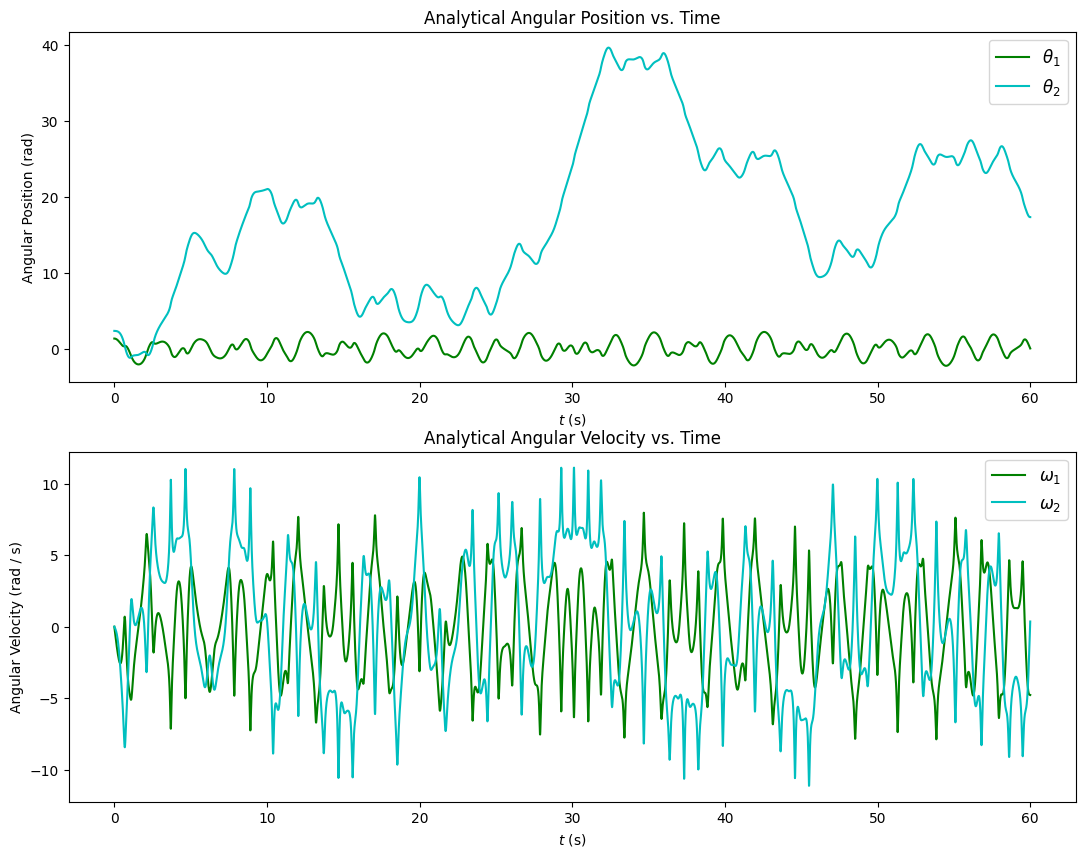

In [6]:
fig, axs = plt.subplots(2,1)

axs[0].set_title("Analytical Angular Position vs. Time")
axs[0].set_xlabel(r'$t$ (s)')
axs[0].set_ylabel("Angular Position (rad)")
axs[0].plot(t, x_analytical[:, 0], 'g-', label=r'$\theta _1$')
axs[0].plot(t, x_analytical[:, 1], 'c-', label=r'$\theta _2$')
axs[0].legend(fontsize=12)

axs[1].set_title(r'Analytical Angular Velocity vs. Time')
axs[1].set_xlabel(r'$t$ (s)')
axs[1].set_ylabel("Angular Velocity (rad / s)")
axs[1].plot(t, x_analytical[:, 2], 'g-', label=r'$\omega _1$')
axs[1].plot(t, x_analytical[:, 3], 'c-', label=r'$\omega _2$')
axs[1].legend(fontsize=12)

fig.set_size_inches(13, 10)
plt.show()

# Generate Training and Test Data

Now we will do the same thing but store it as training data for the model (this code will take a couple seconds to run):

In [7]:
# Using N to divvy up training and test data
N = 2000

# Generate analytical data using Runge-Kutta step
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=t_start, h=dt)))

# Data for the first N timesteps
t = np.arange(N, dtype=np.float32)
x_train = jax.device_get(solve_analytical(x0, t))
xt_train = jax.device_get(jax.vmap(f_analytical)(x_train))
y_train = jax.device_get(analytical_step(x_train))

# Data for the second N timesteps
t_test = np.arange(N, 2*N, dtype=np.float32)
x_test = jax.device_get(solve_analytical(x0, t_test))
xt_test = jax.device_get(jax.vmap(f_analytical)(x_test))
y_test = jax.device_get(analytical_step(x_test))

# The Network Architecture

This architecture is surprisingly simple:

In [8]:
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)


# Lagrangian function for the model to use
def learned_lagrangian(params):
    
    def lagrangian(q, q_t):
        
        state = normalize_dp(jnp.concatenate([q, q_t]))
        return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
        
    return lagrangian


# Loss function for the model to use
@jax.jit
def loss(params, batch, time_step=None):
    
    state, targets = batch
    
    if time_step is not None:
        
        f = partial(equation_of_motion, learned_lagrangian(params))
        preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
        
    else:
        
        preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
        
    return jnp.mean((preds - targets) ** 2)


# Optimization update for the model
@jax.jit
def update_timestep(i, opt_state, batch):
    
    params = get_params(opt_state)
    return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)


# Optimization update for the model
@jax.jit
def update_derivative(i, opt_state, batch):
    
    params = get_params(opt_state)
    return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)


# Prepare data
x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)
x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

# Training the Model

Training the model will take a little more than an hour. There may already be a `pickle` file with trained model weights that you can load. If so, feel free to skip this cell and the next. If not, lean back, sip some coffee, and enjoy watching the loss go down.

In [9]:
# Initialize randomness
rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# Number of batches
num_batches = 2000

# Number of data points in each batch
batch_size = 100

# How many batches between every loss shown on screen
print_every = 100

# Initialize loss arrays
train_losses = []
test_losses = []

# The optimizer is Adam
opt_init, opt_update, get_params = optimizers.adam(lambda t: jnp.select([t < batch_size*(num_batches//3), 
                                                                         t < batch_size*(2*num_batches//3), 
                                                                         t > batch_size*(2*num_batches//3)], 
                                                                        [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

In [8]:
# Training Loop
for iteration in tqdm(range(batch_size*num_batches + 1)):
    
    if iteration % batch_size == 0:

        # Get the parameters of the model
        params = get_params(opt_state)

        # Get the training and test loss using the parameters
        train_loss = loss(params, (x_train, xt_train))
        test_loss = loss(params, (x_test, xt_test))

        # Add to the arrays
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Display losses
        if iteration % (batch_size*print_every) == 0:
            
            print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

    # Update model parameters
    opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

# The final parameters of the trained model
params = get_params(opt_state)

  0%|                                                  | 0/200001 [00:00<?, ?it/s]

iteration=0, train_loss=534.211853, test_loss=39740.210938


  5%|█▊                                  | 10009/200001 [03:18<1:03:10, 50.12it/s]

iteration=10000, train_loss=197.314667, test_loss=209.128036


 10%|███▌                                | 20009/200001 [06:35<1:00:06, 49.91it/s]

iteration=20000, train_loss=181.927292, test_loss=234.657318


 15%|█████▍                              | 30006/200001 [09:53<1:02:42, 45.18it/s]

iteration=30000, train_loss=165.038223, test_loss=172.495102


 20%|███████▌                              | 40009/200001 [13:11<53:23, 49.94it/s]

iteration=40000, train_loss=181.807983, test_loss=191.269730


 25%|█████████▌                            | 50005/200001 [16:28<50:21, 49.64it/s]

iteration=50000, train_loss=180.004852, test_loss=189.231522


 30%|███████████▍                          | 60007/200001 [19:46<46:37, 50.04it/s]

iteration=60000, train_loss=22.502157, test_loss=24.078974


 35%|█████████████▎                        | 70008/200001 [23:04<42:53, 50.51it/s]

iteration=70000, train_loss=0.819444, test_loss=0.946812


 40%|███████████████▏                      | 80004/200001 [26:21<40:14, 49.70it/s]

iteration=80000, train_loss=0.564804, test_loss=0.692524


 45%|█████████████████                     | 90008/200001 [29:39<36:32, 50.16it/s]

iteration=90000, train_loss=0.431115, test_loss=0.473110


 50%|██████████████████▌                  | 100007/200001 [32:57<33:17, 50.07it/s]

iteration=100000, train_loss=0.407649, test_loss=0.430843


 55%|████████████████████▎                | 110010/200001 [36:14<29:56, 50.08it/s]

iteration=110000, train_loss=0.420804, test_loss=0.430755


 60%|██████████████████████▏              | 120008/200001 [39:32<26:42, 49.92it/s]

iteration=120000, train_loss=0.200156, test_loss=0.234416


 65%|████████████████████████             | 130005/200001 [42:49<23:26, 49.77it/s]

iteration=130000, train_loss=0.215223, test_loss=0.231995


 70%|█████████████████████████▉           | 140006/200001 [46:06<20:07, 49.70it/s]

iteration=140000, train_loss=0.136026, test_loss=0.170372


 75%|███████████████████████████▊         | 150007/200001 [49:24<17:21, 48.02it/s]

iteration=150000, train_loss=0.118255, test_loss=0.150290


 80%|█████████████████████████████▌       | 160007/200001 [52:41<13:18, 50.09it/s]

iteration=160000, train_loss=0.095780, test_loss=0.118347


 85%|███████████████████████████████▍     | 170010/200001 [55:58<09:53, 50.54it/s]

iteration=170000, train_loss=0.085116, test_loss=0.106844


 90%|█████████████████████████████████▎   | 180006/200001 [59:16<06:41, 49.83it/s]

iteration=180000, train_loss=0.090614, test_loss=0.117689


 95%|█████████████████████████████████▎ | 190010/200001 [1:02:33<03:19, 50.20it/s]

iteration=190000, train_loss=0.101936, test_loss=0.111792


100%|███████████████████████████████████| 200001/200001 [1:05:50<00:00, 50.63it/s]

iteration=200000, train_loss=0.067870, test_loss=0.083923


# Saving the Model

Run the code below to save the model using `pickle`. Make sure to change the name of the file to whatever you want.

In [18]:
trained_params = optimizers.unpack_optimizer_state(opt_state)
pickle.dump(trained_params, open(os.path.join("./", ""), "wb"))

___

# Loading the Model

The code below loads a model's parameters from a `pickle` file of your choosing. Make sure you change the name of the file to the one you want to load.

In [10]:
s = pickle.load(open(os.path.join("./", "best_model.pkl"), "rb"))
best_opt_state = optimizers.pack_optimizer_state(s)
params = get_params(best_opt_state)

# Model Predictions

We'll get the analytical form again as well as the model predictions:

In [11]:
# choose an initial state
x1 = np.array([theta1_0, theta2_0, omega1_0, omega2_0], dtype=np.float32)
t2 = np.linspace(0, 120, num=6000)
x1_analytical = jax.device_get(solve_analytical(x1, t2))
x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t2))

# Plotting Angles

Let's take a look at the LNN's predictions for the angles.

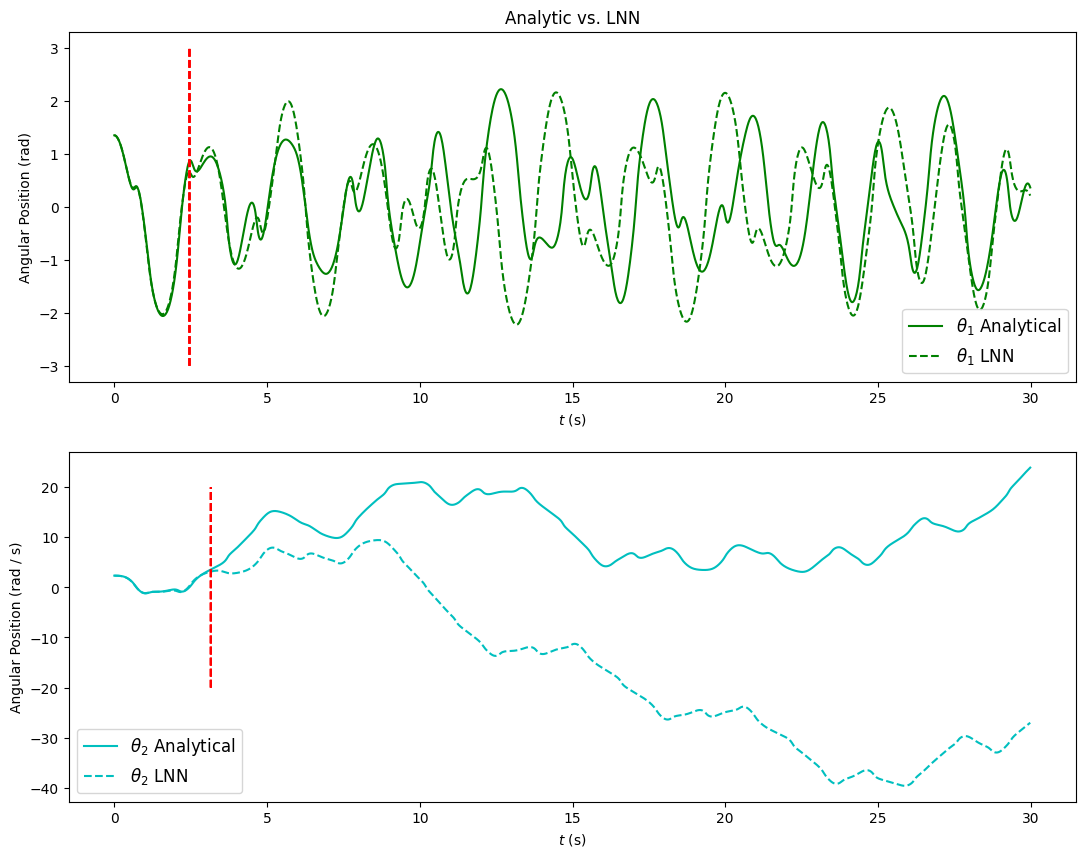

In [12]:
fig, axs = plt.subplots(2,1)

axs[0].set_title("Analytic vs. LNN")
axs[0].set_xlabel(r'$t$ (s)')
axs[0].set_ylabel("Angular Position (rad)")
axs[0].plot(t2[0:1500], x1_analytical[0:1500, 0], 'g-', label=r'$\theta_1$ Analytical')
axs[0].plot(t2[0:1500], x1_model[0:1500, 0], 'g--', label=r'$\theta_1$ LNN')
theta_1_diff = abs(x1_analytical[:, 0] - x1_model[:, 0])
ind1 = np.argmax(theta_1_diff > 0.2)
axs[0].plot(np.ones(x1_model.shape) * t2[ind1], np.linspace(-3, 3, x1_model.shape[0]), 'r--')
axs[0].legend(fontsize=12)

axs[1].set_xlabel(r'$t$ (s)')
axs[1].set_ylabel("Angular Position (rad / s)")
axs[1].plot(t2[0:1500], x1_analytical[0:1500, 1], 'c-', label=r'$\theta_2$ Analytical')
axs[1].plot(t2[0:1500], x1_model[0:1500, 1], 'c--', label=r'$\theta_2$ LNN')
theta_2_diff = abs(x1_analytical[:, 1] - x1_model[:, 1])
ind2 = np.argmax(theta_2_diff > 0.4)
axs[1].plot(np.ones(x1_model.shape) * t2[ind2], np.linspace(-20, 20, x1_model.shape[0]), 'r--')
axs[1].legend(fontsize=12)

fig.set_size_inches(13, 10)
plt.show()

We can see that they still deviate within just a few seconds. Let's look at the predicted Lagrangians:

In [13]:
def get_lagrangians(states, m1=1, m2=1, l1=1, l2=1, g=9.8):
    
    return (0.5 * (m1 + m2) * (l1 ** 2) * (states[:, 2] ** 2)) \
         + (0.5 * m2 * (l2 ** 2) * (states[:, 3] ** 2)) \
         + (m2 * l1 * l2 * states[:, 2] * states[:, 3] * np.cos(states[:, 0] - states[:, 1]) \
         + (((m1 + m2) * g * l1 * np.cos(states[:, 0])) + (m2 * g * l2 * np.cos(states[:, 1]))))
    
analytical_lagrangians = get_lagrangians(x1_analytical)
model_lagrangians = get_lagrangians(x1_model)

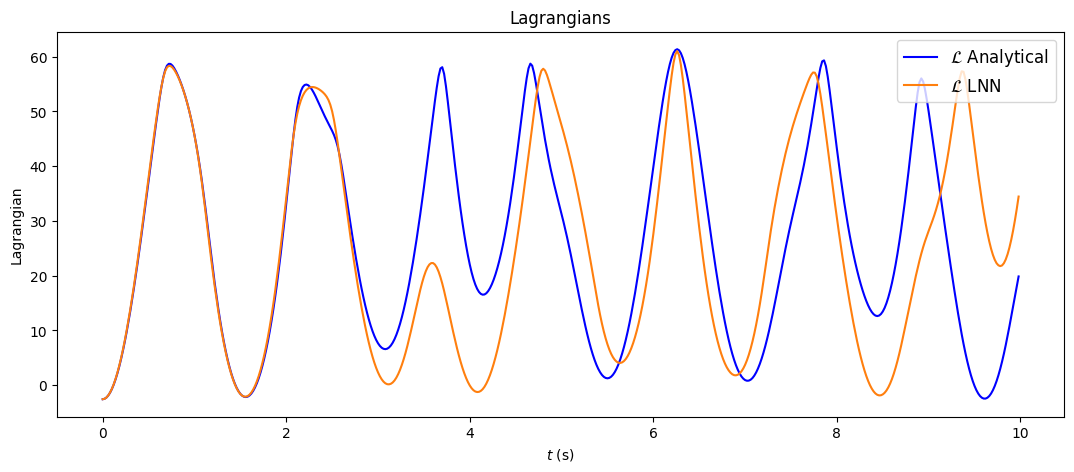

In [14]:
plt.figure(figsize=[13, 5])
plt.title("Lagrangians")
plt.xlabel(r'$t$ (s)')
plt.ylabel("Lagrangian")
plt.plot(t2[0:500], analytical_lagrangians[0:500], 'b', label=r'$\mathcal{L}$ Analytical')
plt.plot(t2[0:500], model_lagrangians[0:500], 'tab:orange', label=r'$\mathcal{L}$ LNN')
plt.legend(fontsize=12)
plt.show()

We can see that the Lagrangians also deviate at around the same time (3 seconds) as the angles, but aren't too far off after. What about the energy?

In [15]:
def get_energies(states, m1=1, m2=1, l1=1, l2=1, g=9.8):

    return (0.5 * (m1 + m2) * (l1 ** 2) * (states[:, 2] ** 2)) \
         + (0.5 * m2 * (l2 ** 2) * (states[:, 3] ** 2)) \
         + (m2 * l1 * l2 * states[:, 2] * states[:, 3] * np.cos(states[:, 0] - states[:, 1]) \
         - (((m1 + m2) * g * l1 * np.cos(states[:, 0])) + (m2 * g * l2 * np.cos(states[:, 1]))))

analytical_energy = get_energies(x1_analytical)
model_energy = get_energies(x1_model)

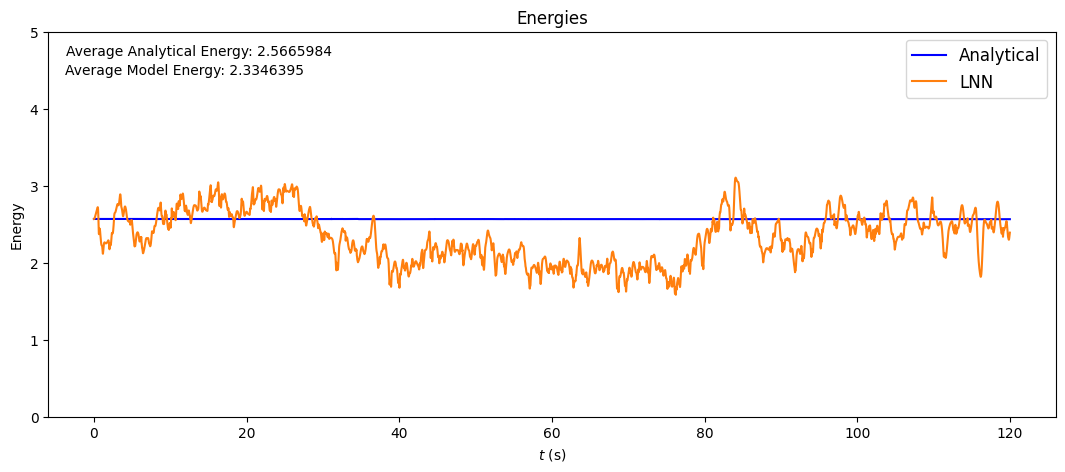

In [16]:
plt.figure(figsize=[13, 5])
ax = plt.gca()
plt.title("Energies")
plt.xlabel(r'$t$ (s)')
plt.ylabel("Energy")
plt.plot(t2, analytical_energy, 'b', label='Analytical')
plt.plot(t2, model_energy, 'tab:orange', label='LNN')
plt.ylim([0, 5])
plt.legend(fontsize=12)
plt.text(0.15, 0.95, 'Average Analytical Energy: ' + str(np.mean(analytical_energy)),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(0.135, 0.9, 'Average Model Energy: ' + str(np.mean(model_energy)),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
plt.show()

We see that the energy seems to dip suspiciously low at around 30 seconds in. However, after almost a full minute, the system snaps back to averaging at the correct energy.

Looking at the energy this way may make it seem like the system is losing energy. Let's try checking with the Lagrangian.

We know that the total derivative of the energy with respect to time is equal to the negative of the partial derivative of the Lagrangian with respect to time:

$$\frac{dE}{dt} = -\frac{\partial \mathcal{L}}{\partial t}$$

If we want to determine if energy is conserved, we have to take the partial derivative with respect to time of the Lagrangian. However, we don't have time as an explicit parameter, so we have to do it in a roundabout way. The total derivative of the Lagrangian tells us:

$$\frac{d\mathcal{L}}{dt} = \frac{\partial \mathcal{L}}{\partial t} + \frac{\partial \mathcal{L}}{\partial q_1}\frac{dq_1}{dt} + \frac{\partial \mathcal{L}}{\partial \dot{q}_1}\frac{d\dot{q}_1}{dt} + \ldots$$

So we simply need to solve for the partial with respect to time. In our case, we have:

$$\frac{\partial \mathcal{L}}{\partial t} = \frac{d\mathcal{L}}{dt} - \left(\frac{\partial \mathcal{L}}{\partial \theta _1}\frac{d\theta _1}{dt} + \frac{\partial \mathcal{L}}{\partial \omega _1}\frac{d\omega _1}{dt} + \frac{\partial \mathcal{L}}{\partial \theta _2}\frac{d\theta _2}{dt} + \frac{\partial \mathcal{L}}{\partial \omega _2}\frac{d\omega _2}{dt}\right)$$

We can get $\frac{d\mathcal{L}}{dt}$ from using `np.gradient` on `model_lagrangians` with respect to `t2`, and we can get each of the coordinate derivatives the same way (e.g., using `np.gradient` on `x1_model[:, 0]` with respect to `t2`). Getting the partial of the Lagrangian with respect to each coordinate can be done by using `scipy`'s `derivative` function on the model Lagrangians with respect to each coordinate:

In [17]:
from scipy.misc import derivative

# Just a helper function so we don't have to do extra work
def easy_lagrangian(state, m1=1, m2=1, l1=1, l2=1, g=9.8):
    
    theta1, theta2, omega1, omega2 = state
    
    T1 = 0.5 * m1 * (l1 * omega1)**2
    T2 = 0.5 * m2 * ((l1 * omega1)**2 + (l2 * omega2)**2 +
                    2 * l1 * l2 * omega1 * omega2 * jnp.cos(theta1 - theta2))
    T = T1 + T2
    
    y1 = -l1 * jnp.cos(theta1)
    y2 = y1 - l2 * jnp.cos(theta2)
    V = m1 * g * y1 + m2 * g * y2
    
    return T - V


dLdtheta1 = []
dLdtheta2 = []
dLdomega1 = []
dLdomega2 = []

# Total Derivative
total_der = np.gradient(analytical_lagrangians, t2)

# Partial derivatives with respect to coordinates
for i in range(x1_analytical.shape[0]):
    
    dLdtheta1.append(derivative(easy_lagrangian, np.array([x1_model[i, 0], 0, 0, 0]), dx=1e-3))
    dLdtheta2.append(derivative(easy_lagrangian, np.array([0, x1_model[i, 1], 0, 0]), dx=1e-3))
    dLdomega1.append(derivative(easy_lagrangian, np.array([0, 0, x1_model[i, 2], 0]), dx=1e-3))
    dLdomega2.append(derivative(easy_lagrangian, np.array([0, 0, 0, x1_model[i, 3]]), dx=1e-3))

dLdtheta1 = np.array(dLdtheta1)
dLdtheta2 = np.array(dLdtheta2)
dLdomega1 = np.array(dLdomega1)
dLdomega2 = np.array(dLdomega2)

# Derivatives of each coordinate with respect to time
dtheta1dt = np.gradient(x1_model[:, 0], t2)
dtheta2dt = np.gradient(x1_model[:, 1], t2)
domega1dt = np.gradient(x1_model[:, 2], t2)
domega2dt = np.gradient(x1_model[:, 3], t2)

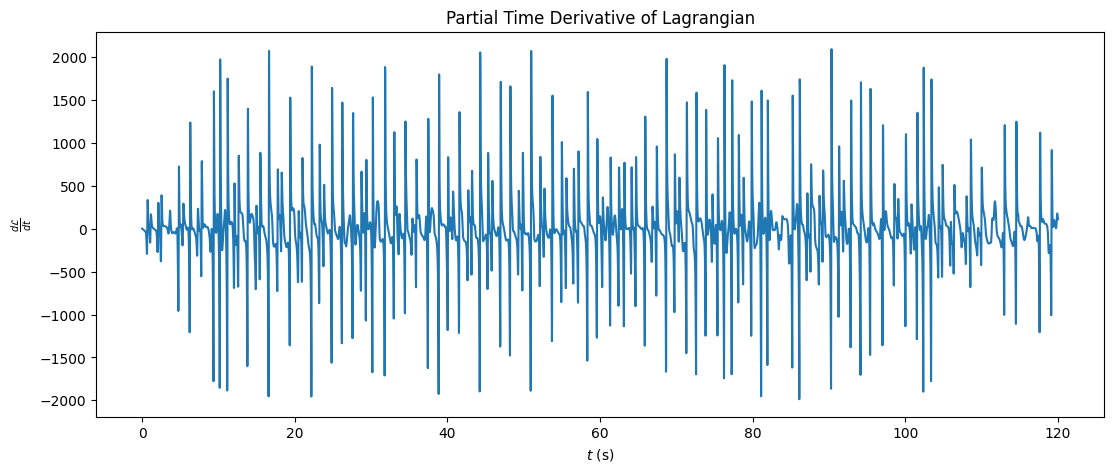

In [18]:
right_side = (dLdtheta1 * dtheta1dt) + (dLdtheta2 * dtheta2dt) + (dLdomega1 * domega1dt) + (dLdomega2 * domega2dt)
all = total_der - right_side

plt.figure(figsize=[13, 5])
plt.title("Partial Time Derivative of Lagrangian")
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\frac{d \mathcal{L}}{dt}$')
plt.plot(t2, all)
plt.show()

Hmmm... this doesn't look quite right, does it? We expected it to be zero, or at least *close* to zero, but it has giant spikes all the way up to the thousands.

However, looking closely, each spike seems to have a spike in the opposite direction of nearly equal magnitude. Let's take the average:

In [19]:
np.mean(all)

0.047098387

Sure enough, the average is almost exactly zero, even with the giant spikes.

But why is this happening? Let's take a closer look:

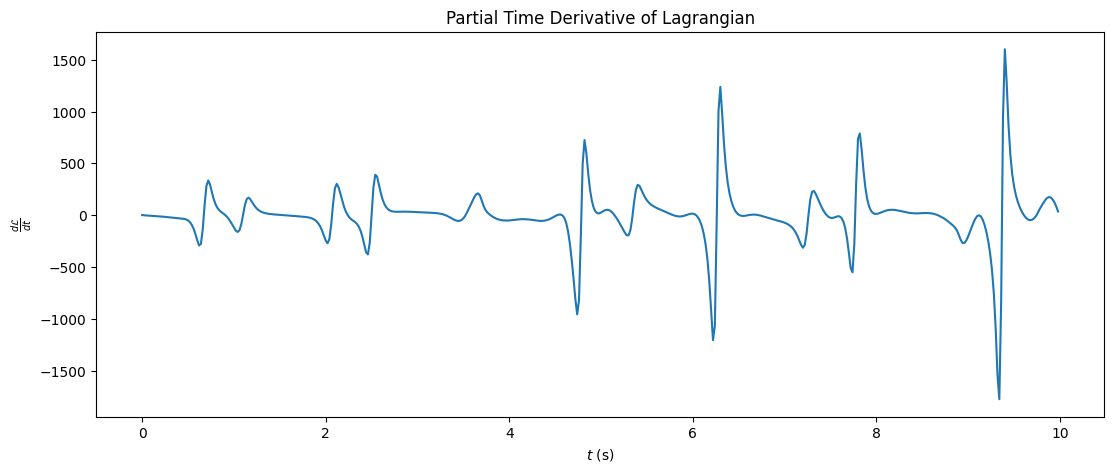

In [20]:
plt.figure(figsize=[13, 5])
plt.title("Partial Time Derivative of Lagrangian")
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\frac{d \mathcal{L}}{dt}$')
plt.plot(t2[0:500], all[0:500])
plt.show()

The key is when $\theta _1$ passes through $0$. Let's plot the Lagrangians again but mark the times where $\theta _1$ passes from negative to positive or vice versa.

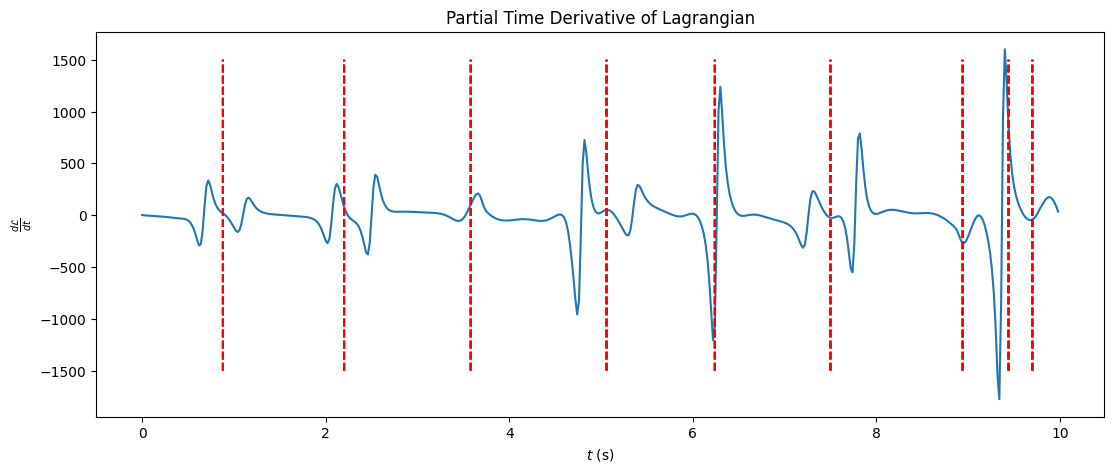

In [21]:
mark_indices = []
for i in range(500):
    if i + 1 == 500:
        break
    if x1_model[i, 0] <= 0 and x1_model[i + 1, 0] >= 0:
        mark_indices.append(i)
    elif x1_model[i, 0] >= 0 and x1_model[i + 1, 0] <= 0:
        mark_indices.append(i)

mark_indices = np.array(mark_indices)

plt.figure(figsize=[13, 5])
plt.title("Partial Time Derivative of Lagrangian")
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\frac{d \mathcal{L}}{dt}$')
plt.plot(t2[0:500], all[0:500])
for ind in mark_indices:
    plt.plot(np.ones(x1_model.shape) * t2[ind], np.linspace(-1500, 1500, x1_model.shape[0]), 'r--')
plt.show()

We can clearly see that these spikes are just artifacts created by the numerical derivative when $\theta _1$ passes through zero.

Therefore, we can safely assume that detecting if energy is conserved from predicted Lagrangians from a neural network is possible.

___

# Symbolic Regression

We would now like to determine the original symbolic equations of the Lagrangian from the predicted data. For this we will be using the `Py-SR` library.

Let's try predicting $\alpha _1$ first:

In [22]:
X = x1_model
y = domega1dt

model1 = PySRRegressor(
    niterations=60,
    binary_operators=["+", "*", "-"],
    unary_operators=[
        "cos",
        "sin",
    ],
    nested_constraints={
        "cos": {"cos": 0, "sin": 0},
        "sin": {"sin": 0, "cos": 0}
    },
    progress=False,
    verbosity=0,
    delete_tempfiles=True
)

model1.fit(X, y, variable_names=['t1', 't2', 'w1', 'w2'])

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       -0.006112835   
	1         0.032921                                            sin(t2)   
	2         0.333648                                      -8.23152 * t1   
	3         0.053485                               -13.190241 * sin(t1)   
	4         0.094719                          (sin(t2) - t1) * 8.478899   
	5         0.039527                    11.087843 * (sin(t2) - sin(t1))   
	6         0.367630                           sin(t2 - t1) * (w2 * w2)   
	7         0.138976            (sin(t2 - t1) * (w2 * w2)) * 0.74197316   
	8         0.096588      (sin(t2 - t1) * (w2 * (w2 * 0.7306987))) - t1   
	9         0.332957  ((sin(t2 - t1) * (w2 * w2)) * 0.67518055) - (t...   
	10        0.114389  (((w2 * w2) * sin(t2 - t1)) * 0.6837708) - (si...   
	11        0.075522  ((sin(t2 - t1) * (w2 * (w2 - w1))) * 0.6751805...   
	12  >>>>  0.257571  ((((w2 - w1) * w2) * sin(t2 - t1)) * 0.5537125...   
	13        0.013224  (((w2 * (w2 - w1)) * sin(t2 - t1)) * sin(0.610...   
	14        0.001746  (((sin(t2 - t1) * (w2 * (w2 - w1))) * 0.576856...   
	15        0.018637  ((((w2 * (w2 - w1)) + 1.3855422) * sin(t2 - t1...   
	
	          loss  complexity  
	0   263.642430           1  
	1   255.104370           2  
	2   182.732790           3  
	3   173.216080           4  
	4   143.323010           6  
	5   137.768430           7  
	6    95.387210           8  
	7    72.239914          10  
	8    59.550007          12  
	9    30.596994          14  
	10   27.289783          15  
	11   25.304708          16  
	12   19.558681          17  
	13   19.301731          18  
	14   19.268064          19  
	15   18.912300          20  
]

In [23]:
model1.sympy()

-0.5537125*w2*(-w1 + w2)*sin(t1 - t2) - 9.483368*sin(t1)

Not too bad, especially considering we tried to find an equation that would match the entire two minute prediction. We can see some similarities when comparing it to the actual equation, such as the sine of the difference of the angles and the squared $\omega _2$ term attached.

Let's take a look at the plot of this equation as compared to the *analytical* data for $\alpha _1$:

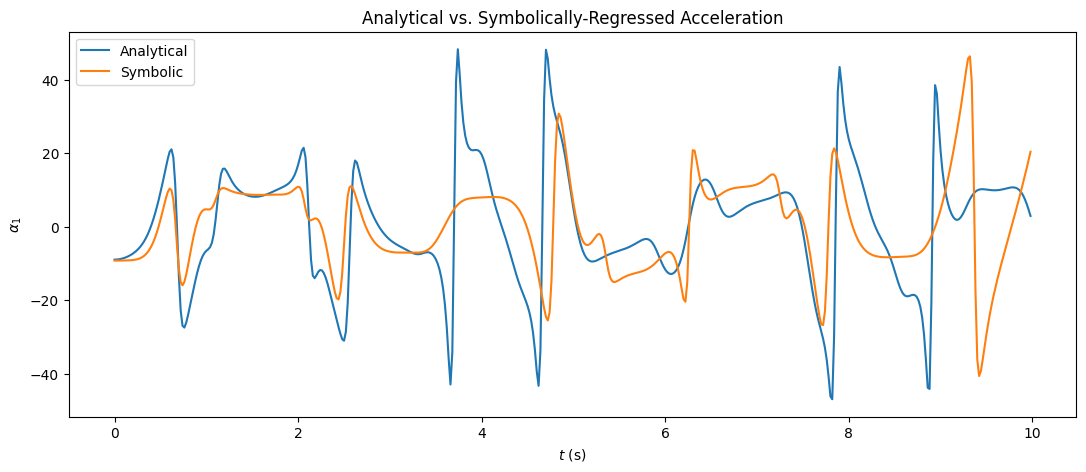

In [24]:
alpha1_analytical = np.gradient(x1_analytical[:, 2], t2)

plt.figure(figsize=[13, 5])
plt.title("Analytical vs. Symbolically-Regressed Acceleration")
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\alpha _1$')
plt.plot(t2[0:500], alpha1_analytical[0:500], label='Analytical')
plt.plot(t2[0:500], model1.predict(X)[0:500], label='Symbolic')
plt.legend()
plt.show()

We can see that the symbolically-regressed equation's plot actually follows (somewhat) closely to the analytical data.

Let's take a look at the other acceleration (it shouldn't be much different):

In [28]:
X = x1_model
y = domega2dt

model2 = PySRRegressor(
    niterations=60,
    binary_operators=["+", "*", "-"],
    unary_operators=[
        "cos",
        "sin",
    ],
    nested_constraints={
        "cos": {"cos": 0, "sin": 0},
        "sin": {"sin": 0, "cos": 0}
    },
    progress=True,
    verbosity=0,
    delete_tempfiles=True
)

model2.fit(X, y, variable_names=['t1', 't2', 'w1', 'w2'])

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                                 t1   
	1         0.001742                                     2.0231144 * t1   
	2         0.333578                               -15.301206 * sin(t2)   
	3         0.120630                          -16.580265 * sin(t2 - t1)   
	4         0.199604                           (sin(t1 - t2) * w1) * w1   
	5   >>>>  0.251703             1.7731879 * ((w1 * sin(t1 - t2)) * w1)   
	6         0.033278      ((w1 * (w1 * sin(t1 - t2))) - t1) * 1.8342365   
	7         0.007438  (w1 * (w1 * sin(t1 - t2))) * (1.0343693 + cos(...   
	8         0.074003  w1 * (sin(t1 - t2) * (w1 + (0.4955093 * (w1 - ...   
	9         0.018790  (w1 * (sin(t1 - t2) * (w1 + (0.4955093 * (w1 -...   
	10        0.054807  w1 * (sin(t1 - t2) * (((w1 * cos(t1)) + w1) - ...   
	11        0.006009  w1 * (sin(t1 - t2) * (((w1 * (cos(t1) * 0.8504...   
	12        0.000616  w1 * (sin(t1 - t2) * (((w1 * (cos(t1) * cos(0....   
	
	          loss  complexity  
	0   360.676670           1  
	1   359.422120           3  
	2   257.474150           4  
	3   202.281400           6  
	4   135.700580           8  
	5    82.026634          10  
	6    76.744934          12  
	7    76.176250          13  
	8    70.742540          14  
	9    68.133380          16  
	10   64.499650          17  
	11   63.729156          19  
	12   63.689884          20  
]

In [29]:
model2.sympy()

1.7731879*w1**2*sin(t1 - t2)

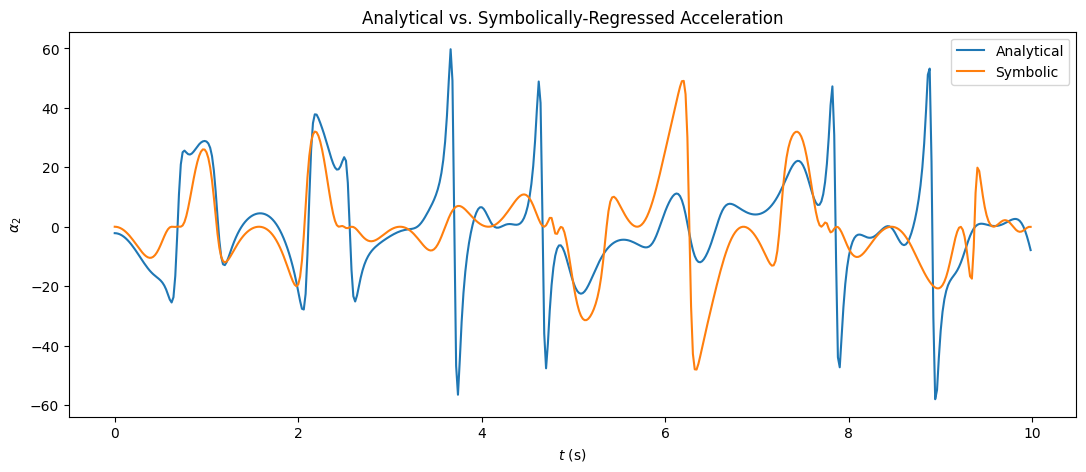

In [30]:
alpha2_analytical = np.gradient(x1_analytical[:, 3], t2)

plt.figure(figsize=[13, 5])
plt.title("Analytical vs. Symbolically-Regressed Acceleration")
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\alpha _2$')
plt.plot(t2[0:500], alpha2_analytical[0:500], label='Analytical')
plt.plot(t2[0:500], model2.predict(X)[0:500], label='Symbolic')
plt.legend()
plt.show()

Again, we see that there is a close resemblance between the correct motion and the motion that was determined by symbolic regression from integration of a neural network's predictions of the system's Lagrangian (what a mouthful!).

# Conclusion

We can see that Lagrangian Neural Networks can indeed predict the motion of complex systems fairly accurately, but more importantly, we can detect whether a system contains conserved quantities just from the predicted Lagrangian. Additionally, we can use symbolic regression on the predicted motion (determined from the Lagrangian) to get a symbolic form of the predicted governing equations. These equations are not perfectly accurate (the symbolic regression parameters were surely not selected perfectly), but these symbolically-regressed equations can surely give insight into the true form of a black-box system's governing equations.

# Thank You

A very large thank you to Miles Cranmer for his wonderful [paper](https://arxiv.org/abs/2003.04630) on the subject, as well as already implemented [code](https://github.com/MilesCranmer/lagrangian_nns) (which this code was **heavily** based on), and for the creation of the wonderful [Py-SR](https://github.com/MilesCranmer/PySR). More thank you's to Sam Greydanus for his great [blog post](https://greydanus.github.io/2020/03/10/lagrangian-nns/) about this subject, as well as code, and another to Stephan Hoyer for his code as well. Lastly, one more thank you to Diego Assencio for the easy-to-follow [derivations](https://dassencio.org/33) on this topic.

Oh, and to you, the reader, thank you.